# hetan: ridge regression on macro variables and a basket of related stocks is what i’d suggest

In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
rcParams['figure.figsize']=20,10
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
import pandas_datareader as pdr
import quantstats as qs
import pytz

import datetime as dt

from sklearn import linear_model

In [3]:
snp_data = pd.read_csv('../Data/snp500.csv')
snp = pd.Series(snp_data[['Symbol']].squeeze()).tolist()

In [4]:
pd.__version__

'1.4.3'

# Try Hetan's suggestion - rough generalization of pairs trading on multiple assets

In [4]:
# tickerName: string, a single ticker
# period can be '_mo', '_
def downloadClosingPrices(tickerName, period='6mo'):
    return yf.Ticker(tickerName).history(period=period)[['Close']]

# closingPrices: a Pandas Dataframe of closing prices
# returns a list of returns
def getReturns(closingPrices):
    return closingPrices.pct_change(1).dropna() #closingPrices.diff().reset_index(drop=True)[1:].reset_index(drop=True).div(closingPrices[:-1].reset_index(drop=True))

# tickerNames: a list of strings of ticker names
# returns a dictionary of ticker names to lists of their daily returns
def makeDailyReturnsDf(tickerNames, period='6mo'):
    ticker_data = {}
  
    longestIndex = pd.Series(dtype='float64')
    # retrieve data
    for t in tickerNames:
        # take over the past 6 months
        c = downloadClosingPrices(t, period)
        # store longest index
        if len(c.index) >= len(longestIndex):
            longestIndex = c.index[1:]
        # No data found, symbol may be delisted
        if len(c) == 0:
            continue
        else:
            ticker_data[t] = getReturns(c).rename(columns={"Close":t}).squeeze().tolist()
    # remove stocks which are not of the same length
    lens = [len(v) for v in ticker_data.values()]
    longest = max(lens)
    ticker_data_copy = ticker_data.copy()
    for k, v in ticker_data_copy.items():
        if len(v) < longest:
            ticker_data.pop(k)
    # ticker_data
    return pd.DataFrame(ticker_data, index = longestIndex)

# tickersToPredict DOESN'T have to be a subset of tickers
# returns a dictionary with the name of the stock as keys and the LM predicting that stock as values
# trains pair-wise LMs using same-day returns of related stocks as predictors
def trainLM(tickers, tickerToPredict):

    X = makeDailyReturnsDf(tickers)
    y = makeDailyReturnsDf([tickerToPredict])

    lm = Ridge()
    if tickerToPredict in X.columns:
        X.drop(columns=tickerToPredict, inplace=True)
    lm.fit(X, y)
    print(tickerToPredict, lm.score(X, y))
    return lm

In [5]:
# TODO: change to return series?
## zscore fn to generate buy/sell signals on a daily basis
# takes the zscore of a particular day's prediction over a window of past days
# lm: the linear model predicting stock returns based on related stocks
# X: a dataframe of predictors - returns of stocks related to the target
# y: a list of the target stock's returns
# days: number of days back to scale over
def zscore(lm, X, y, days=30):
    # lookback = min(len(X), len(y), days)
    lookback = days
    # print('lookback',lookback)
    steps = len(X)
    z_ts = []
    for s in range(steps,lookback,-1):
        X_window, y_window = X.iloc[s-lookback:s,], y.iloc[s-lookback:s]
        # predict for the last lookback no. of days
        y_hats = lm.predict(X_window)
        # get the residuals
        y_res = y_window - y_hats

        # get residual for today
        y_res_t = y_res.iloc[-1]
        y_res_ex_t = y_res.iloc[:-1]

        scaler = StandardScaler()
        # fit scale based on residuals up to yesterday
        scaler.fit(np.asarray(y_res_ex_t).reshape(-1,1))

        # transform today's residual
        z_t = scaler.transform(np.asarray(y_res_t).reshape(-1,1))
        z_ts.append(z_t[0][0])
    return z_ts

## Feed all IT stocks as predictors

In [9]:
spy = makeDailyReturnsDf(["SPY"], '4y')
spy

,SPY
Date,
2018-11-05 00:00:00-05:00,0.005517
2018-11-06 00:00:00-05:00,0.006328
2018-11-07 00:00:00-05:00,0.021409
2018-11-08 00:00:00-05:00,-0.001815
2018-11-09 00:00:00-05:00,-0.009768
...,...
2022-10-26 00:00:00-04:00,-0.007534
2022-10-27 00:00:00-04:00,-0.005340
2022-10-28 00:00:00-04:00,0.023791


In [6]:
from statsmodels.regression.rolling import RollingOLS
import statsmodels.api as sm
from tqdm import tqdm

def logPriceFromRets(yhist):
    return np.log(np.cumprod(1+yhist))

def Model(tickers_to_predict, tickers_as_predictors, window = 120, lookback = 30, thresh = 1, rets = True, intercept = False):
    retsSpreads = []
    for tick in tqdm(tickers_to_predict):
        Xhist = makeDailyReturnsDf([t for t in tickers_as_predictors if t != tick], '4y')
        yhist = makeDailyReturnsDf([tick],'4y')
        Xyhist = pd.concat([Xhist, yhist], axis=1)
        if rets:
            if intercept:
                ols = RollingOLS(yhist, sm.add_constant(Xhist), window=window).fit()
            else:
                ols = RollingOLS(yhist, Xhist, window=window).fit()
            betas = ols.params.dropna()
        else:
            if intercept:
                ols = RollingOLS(logPriceFromRets(yhist), 
                            sm.add_constant(logPriceFromRets(Xhist)), window=window).fit()
            else:
                ols = RollingOLS(logPriceFromRets(yhist), 
                            logPriceFromRets(Xhist), window=window).fit()
            betas = ols.params.dropna()
        if intercept:
            if rets:
                spread = yhist[tick] - (betas * sm.add_constant(Xhist)).sum(1)
            else:
                spread = logPriceFromRets(yhist[tick]) - (betas * sm.add_constant(logPriceFromRets(Xhist))).sum(1)
            weights = sm.add_constant(betas.drop('const', axis=1)).rename({'const':tick}, axis=1)
            weights = weights.div(weights.abs().sum(1), axis=0)
        else:
            if rets:
                spread = yhist[tick] - (betas * (Xhist)).sum(1)
            else:
                spread = logPriceFromRets(yhist[tick]) - (betas * logPriceFromRets(Xhist)).sum(1)
            weights = sm.add_constant(betas).rename({'const':tick}, axis=1)
            weights = weights.div(weights.abs().sum(1), axis=0)
        print('ols.rsquared', ols.rsquared)
        zscore = (spread - spread.ewm(lookback).mean())/spread.ewm(lookback).std()
        signals = -(zscore>thresh).astype(int) + (zscore<thresh).astype(int)
        retsSpreads.append((weights.mul(signals,0).shift(1) * 
                            Xyhist.reindex(betas.index).dropna()).sum(1))
    retsSpreads = pd.DataFrame(retsSpreads).T.reindex(betas.index).dropna().reset_index()

    retsSpreads['Date'] = retsSpreads['Date'].dt.tz_localize(None)
    retsSpreads.index = retsSpreads['Date']
    retsSpreads.drop(columns=['Date'], inplace=True)
    qs.reports.full(retsSpreads.mean(1), rf=0.02)
# , benchmark='SPY', match_dates=True)

In [7]:
top20_it_stocks = snp_data[snp_data['GICS Sector'] == 'Information Technology']['Symbol'].to_list()[:20]
top20_stocks = snp_data['Symbol'].to_list()[:20]
top20_comm_stocks = snp_data[snp_data['GICS Sector']=='Communication Services']['Symbol'].to_list()[:20]
top20_it_comm_stocks = snp_data[snp_data['GICS Sector'].isin(['Information Technology', 'Communication Services'])]['Symbol'].to_list()[:20]
# tickers_to_predict = ['AAPL', 'GOOG', 'AMZN']
# tickers_to_predict = ['META','AAPL', 'GOOG', 'AMZN', 'TSLA']

In [56]:
top20_it_comm_stocks

['AAPL',
 'MSFT',
 'GOOG',
 'GOOGL',
 'META',
 'V',
 'NVDA',
 'MA',
 'AVGO',
 'DIS',
 'ORCL',
 'ACN',
 'TMUS',
 'CSCO',
 'VZ',
 'CRM',
 'TXN',
 'ADBE',
 'CMCSA',
 'QCOM']

In [46]:
snp_data[:20]

,Symbol,Description,Category2,Category3,GICS Sector,Market cap,Dividend yield,Price to TTM earnings,Price to TTM sales,Price to book value,Action
0,AAPL,Apple Inc,Common stocks,Large cap,Information Technology,"$2,297,956,828,480",0.63%,21.82,5.95,33.00,Analyze
1,MSFT,Microsoft Corp,Common stocks,Large cap,Information Technology,"$1,746,936,592,097",1.06%,23.53,9.07,10.46,Analyze
2,GOOG,Alphabet Inc Class C,Common stocks,Large cap,Communication Services,"$1,208,476,490,000",0.00%,8.04,4.47,2.36,Analyze
3,GOOGL,Alphabet Inc Class A,Common stocks,Large cap,Communication Services,"$1,208,476,490,000",0.00%,7.77,4.47,2.28,Analyze
4,AMZN,Amazon.Com Inc.,Common stocks,Large cap,Consumer Discretionary,"$1,146,405,543,670",0.00%,50.86,2.40,8.13,Analyze
5,TSLA,Tesla Inc,Common stocks,Large cap,Consumer Discretionary,"$694,752,978,377",0.00%,76.48,11.17,18.84,Analyze
6,BRK.B,Berkshire Hathaway Inc. Class B,Common stocks,Large cap,Financials,"$607,926,273,447",0.00%,4.25,1.71,0.69,Analyze
7,UNH,Unitedhealth Group Inc,Common stocks,Large cap,Health Care,"$476,960,997,656",1.21%,27.51,1.62,6.60,Analyze
8,JNJ,Johnson & Johnson,Common stocks,Large cap,Health Care,"$434,209,059,659",2.63%,21.81,4.58,5.79,Analyze
9,XOM,Exxon Mobil Corp,Common stocks,Large cap,Energy,"$424,557,109,372",3.40%,16.03,1.38,2.44,Analyze


In [8]:
snp_data[snp_data['GICS Sector']=='Communication Services']

,Symbol,Description,Category2,Category3,GICS Sector,Market cap,Dividend yield,Price to TTM earnings,Price to TTM sales,Price to book value,Action
2,GOOG,Alphabet Inc Class C,Common stocks,Large cap,Communication Services,"$1,208,476,490,000",0.00%,8.04,4.47,2.36,Analyze
3,GOOGL,Alphabet Inc Class A,Common stocks,Large cap,Communication Services,"$1,208,476,490,000",0.00%,7.77,4.47,2.28,Analyze
11,META,"Meta Platforms, Inc.",Common stocks,Large cap,Communication Services,"$350,480,100,000",0.00%,0.00,0.00,0.00,Analyze
32,DIS,Walt Disney,Common stocks,Large cap,Communication Services,"$176,180,303,569",0.00%,64.95,2.30,1.90,Analyze
35,TMUS,T Mobile US Inc,Common stocks,Large cap,Communication Services,"$166,887,807,687",0.00%,58.82,2.07,2.36,Analyze
39,VZ,Verizon Communications Inc,Common stocks,Large cap,Communication Services,"$152,869,614,206",6.92%,7.14,1.14,1.82,Analyze
50,CMCSA,Comcast A Corp,Common stocks,Large cap,Communication Services,"$133,126,692,015",3.48%,9.20,1.11,1.40,Analyze
65,T,AT&T Inc.,Common stocks,Large cap,Communication Services,"$107,805,600,000",7.91%,6.24,0.66,0.57,Analyze
69,NFLX,Netflix Inc,Common stocks,Large cap,Communication Services,"$102,721,757,310",0.00%,20.29,3.38,5.79,Analyze
124,ATVI,Activision Blizzard Inc,Common stocks,Large cap,Communication Services,"$57,202,258,007",0.64%,22.81,6.89,3.16,Analyze


In [57]:
Model(['AAPL'], top20_comm_stocks)

  0%|          | 0/1 [00:02<?, ?it/s]


ValueError: Length of values (1002) does not match length of index (1005)

100%|██████████| 1/1 [00:06<00:00,  6.74s/it]

ols.rsquared Date
2018-11-05 00:00:00-05:00    NaN
2018-11-06 00:00:00-05:00    NaN
2018-11-07 00:00:00-05:00    NaN
2018-11-08 00:00:00-05:00    NaN
2018-11-09 00:00:00-05:00    NaN
                            ... 
2022-10-26 00:00:00-04:00    1.0
2022-10-27 00:00:00-04:00    1.0
2022-10-28 00:00:00-04:00    1.0
2022-10-31 00:00:00-04:00    1.0
2022-11-01 00:00:00-04:00    1.0
Length: 1005, dtype: float64


                           Strategy
-------------------------  ----------
Start Period               2019-04-30
End Period                 2022-11-01
Risk-Free Rate             2.0%
Time in Market             100.0%

Cumulative Return          209.28%
CAGR﹪                     37.95%

Sharpe                     1.04
Prob. Sharpe Ratio         92.77%
Smart Sharpe               0.89
Sortino                    1.53
Smart Sortino              1.31
Sortino/√2                 1.08
Smart Sortino/√2           0.93
Omega                      1.2

Max Drawdown               -31.43%
Longest DD Days            301
Volatility (ann.)          34.75%
Calmar                     1.21
Skew                       -0.03
Kurtosis                   4.48

Expected Daily %           0.13%
Expected Monthly %         2.6%
Expected Yearly %          32.61%
Kelly Criterion            9.32%
Risk of Ruin               0.0%
Daily Value-at-Risk        -3.45%
Expected Shortfall (cVaR)  -3.45%

Max Consecutive Wins     

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2020-02-13,2020-03-23,2020-06-05,113,-31.426144,-29.937741
2,2022-01-04,2022-06-16,2022-11-01,301,-28.346083,-26.858585
3,2020-09-02,2020-09-18,2020-12-28,117,-20.375460,-20.166776
4,2021-01-27,2021-03-08,2021-07-07,161,-18.598594,-16.066211
5,2019-05-06,2019-06-03,2019-07-31,86,-17.842526,-17.003440


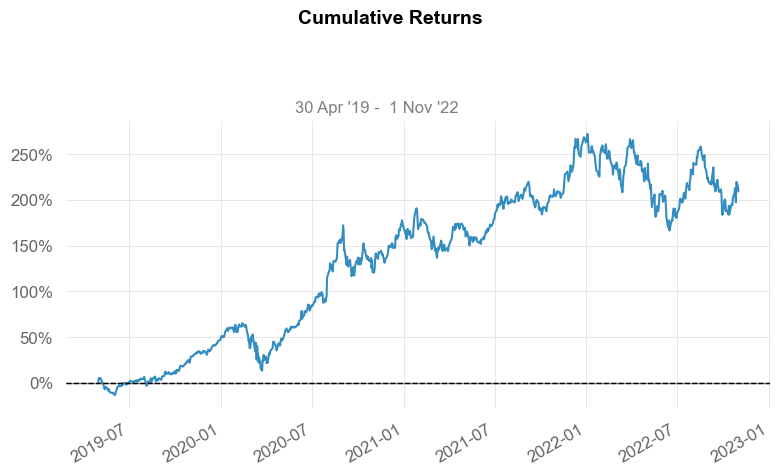

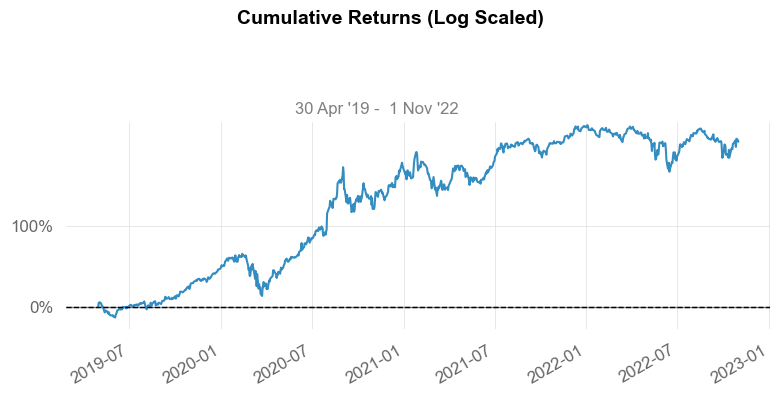

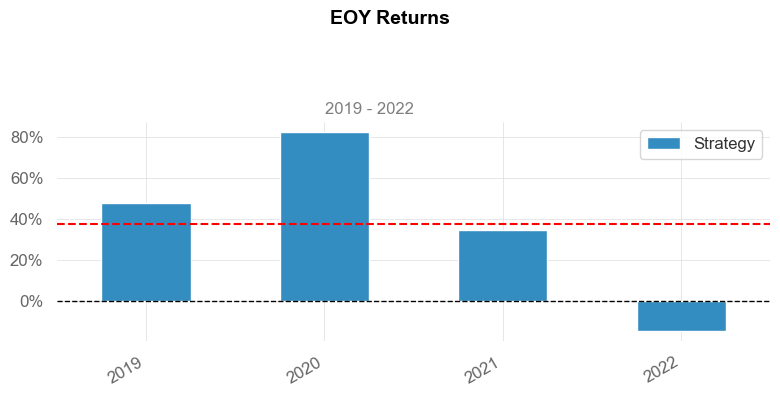

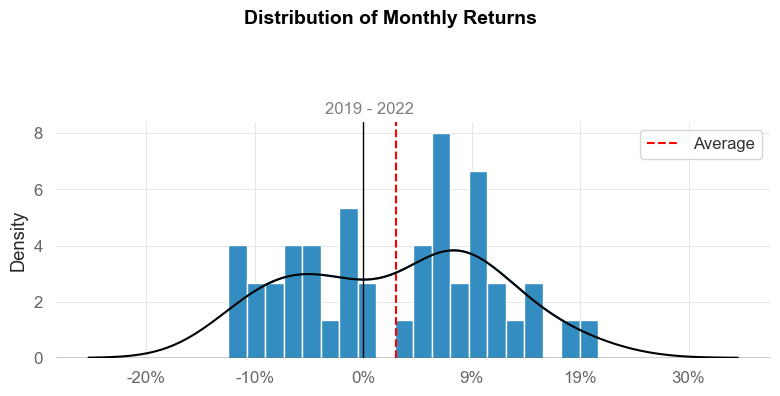

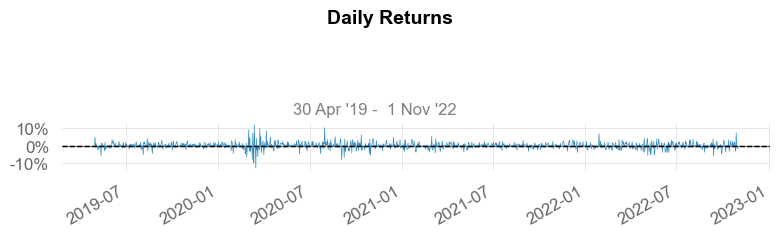

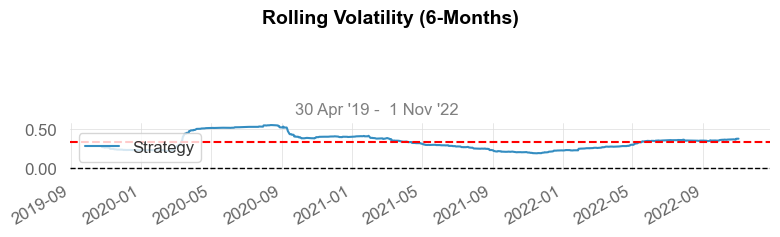

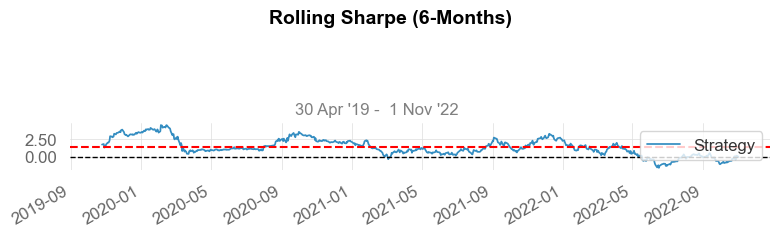

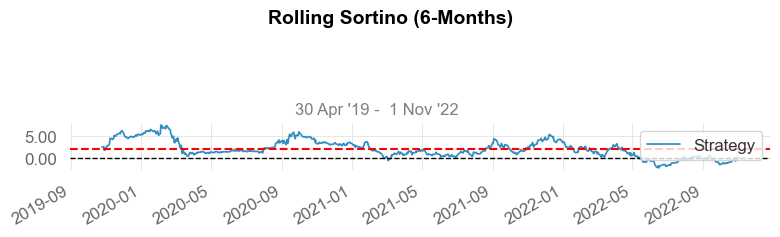

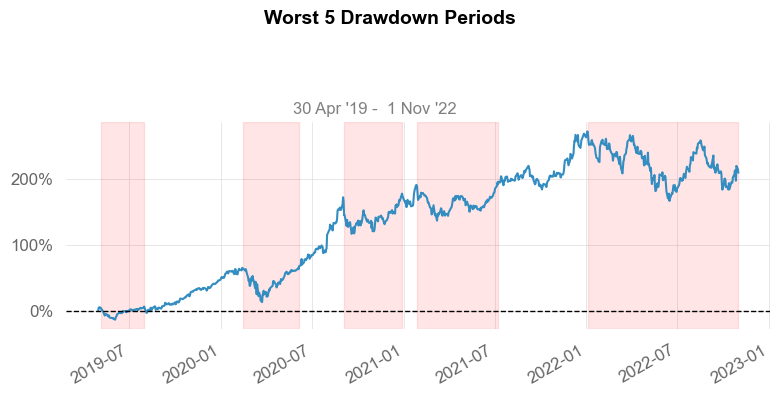

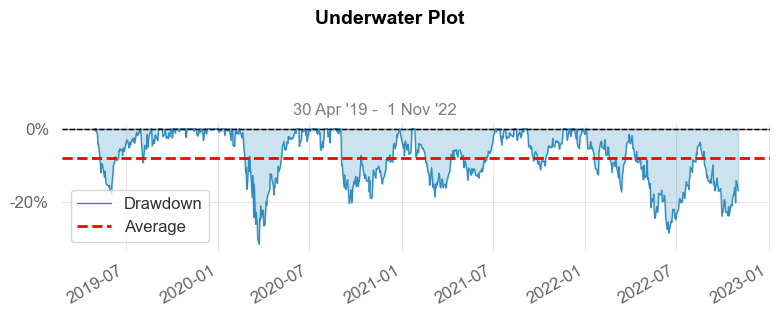

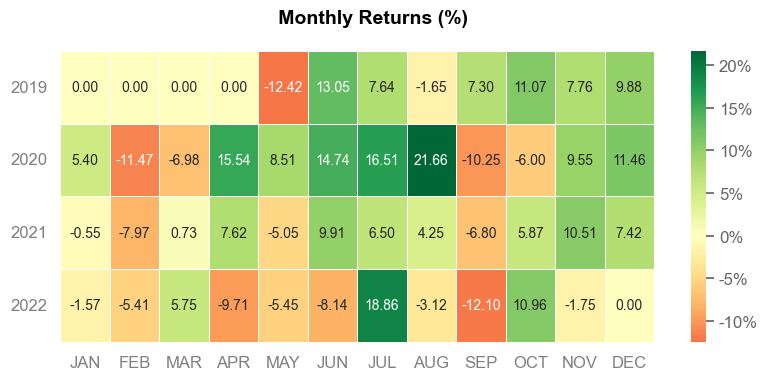

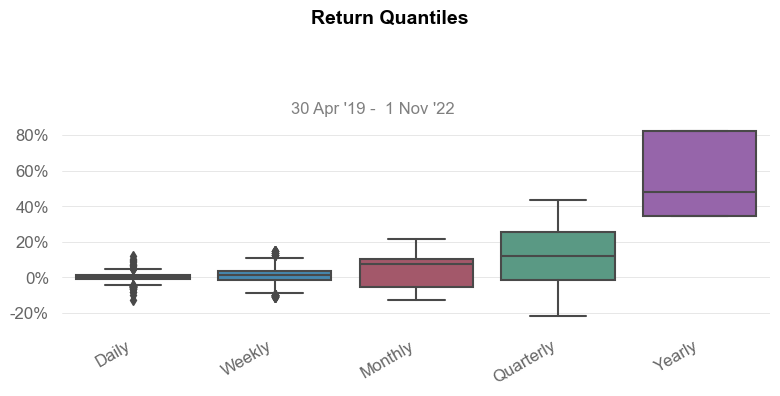

In [58]:
Model(['AAPl'], top20_it_comm_stocks)

# Try Model with incorporation of sentiment

In [22]:
top20_it_stocks_df = makeDailyReturnsDf(top20_it_stocks)
top20_it_stocks_df.to_csv('../Data/Structured_Data/top20_it_stocks.csv')

In [21]:
top20_it_comm_stocks_df = makeDailyReturnsDf(top20_it_comm_stocks, '1y')
top20_it_comm_stocks_df.to_csv('../Data/Structured_Data/top20_it_comm_stocks.csv')

In [11]:
AAPL = makeDailyReturnsDf(['AAPL'], '1y')
AAPL.to_csv('../Data/Structured_Data/AAPL.csv')


In [12]:
TSLA = makeDailyReturnsDf(['TSLA'], '1y')
TSLA.to_csv('../Data/Structured_Data/TSLA.csv')
META = makeDailyReturnsDf(['META'], '1y')
META.to_csv('../Data/Structured_Data/META.csv')

In [105]:
aapl = pd.read_csv('../Data/Structured_Data/AAPL.csv',index_col=0, parse_dates=True, infer_datetime_format=True)
aapl.index = pd.to_datetime(aapl.index, utc=True).date
aapl.index.rename('Date', inplace=True)
print(type(aapl.index))
print(type(aapl.index[0]))

<class 'pandas.core.indexes.base.Index'>
<class 'datetime.date'>


In [106]:
sent = pd.read_csv('../Data-Predictions/returns/finbert_pred_returns_rfr_test.csv', index_col=0)[['AAPL']]
sent.index = pd.to_datetime(sent.index, utc=True).date
sent.index.rename('Date', inplace=True)
print(type(sent.index))
print(type(sent.index[0]))

datetime.date

In [111]:
inner = aapl.merge(sent, how='inner', left_index=True, right_index=True, suffixes=('_rets','_sent'))
inner

,AAPL_rets,AAPL_sent
Date,,
2021-12-23,0.003644,0.002534
2021-12-27,0.022975,-0.002192
2021-12-28,-0.005767,-0.006985
2021-12-29,0.000502,0.004252
2021-12-30,-0.006578,-0.004732
...,...,...
2022-08-25,0.014923,-0.006286
2022-08-26,-0.037699,-0.004005
2022-08-29,-0.013690,-0.012673


In [116]:
print(aapl.shape)
print(aapl.loc[inner.index,:].shape)

(251, 1)
(173, 1)


In [16]:
def readDailyReturnsFromCsv(tickerNames, period='6mo', filepath='../Data/Structured_Data/'):
    ticker_data = {}
    longestIndex = pd.Series(dtype='float64')
    for t in tickerNames:
        df = pd.read_csv(filepath+t+'.csv', index_col=0, parse_dates=True, infer_datetime_format=True)
        df.index = pd.to_datetime(df.index, utc=True).date
        df.index.rename('Date', inplace=True)
        ticker_data[t] = df
        if df.shape[0] >= len(longestIndex):
            longestIndex = df.index[1:]
    lens = [len(v) for v in ticker_data.values()]
    longest = max(lens)
    ticker_data_copy = ticker_data.copy()
    for k, v in ticker_data_copy.items():
        if len(v) < longest:
            ticker_data.pop(k)
    combined = pd.concat(list(ticker_data.values()))
    return combined
    

In [18]:
readDailyReturnsFromCsv(['TSLA',])

,TSLA
Date,
2021-11-08,-0.048401
2021-11-09,-0.119903
2021-11-10,0.043429
2021-11-11,-0.004158
2021-11-12,-0.028293
...,...
2022-10-31,-0.004289
2022-11-01,0.001231
2022-11-02,-0.056360


In [26]:
from statsmodels.regression.rolling import RollingOLS
import statsmodels.api as sm
from tqdm import tqdm

def logPriceFromRets(yhist):
    return np.log(np.cumprod(1+yhist))

def ModelwSentiment(tickers_to_predict=['AAPL'], 
        tickers_as_predictors=['top20_it_comm_stocks'], 
        sentiment_filepath = '../Data-Predictions', sentiment_file = '/returns/finbert_pred_returns_rfr_test.csv', 
        window = 120, lookback = 30, thresh = 1, rets = True, intercept = False):
    retsSpreads = []
    for tick in tqdm(tickers_to_predict):
        #TODO: read from csv file instead of pulling live data to match the sentiment predictions by Elton
        # yhist = pd.read_csv('../Data/Structured_Data/aapl.csv',index_col=0, parse_dates=True, infer_datetime_format=True)
        yhist = readDailyReturnsFromCsv(tickers_to_predict)
        yhist.index = pd.to_datetime(yhist.index, utc=True).date
        yhist.index.rename('Date', inplace=True)


        # returns data
        # Xhist_rets = pd.read_csv('../Data/Structured_Data/top20_it_comm_stocks_df.csv',index_col=0, parse_dates=True, infer_datetime_format=True)
        Xhist_rets = readDailyReturnsFromCsv(tickers_as_predictors)
        Xhist_rets.index = pd.to_datetime(Xhist_rets.index, utc=True).date
        Xhist_rets.index.rename('Date', inplace=True)

        # sentiment data
        Xhist_sent = pd.read_csv(sentiment_filepath + sentiment_file, index_col=0)[tickers_to_predict]
        Xhist_sent.index = pd.to_datetime(Xhist_sent.index, utc=True).date
        Xhist_sent.index.rename('Date', inplace=True)

        # merge only on the dates that overlap
        Xhist = Xhist_rets.merge(Xhist_sent, how='inner', left_index=True, right_index=True, suffixes=('_rets','_sent'))
        yhist = yhist.loc[Xhist.index,:]

        Xyhist = pd.concat([Xhist, yhist], axis=1)
        print('Xhist.shape', Xhist.shape)
        print('yhist.shape', yhist.shape)
        print('Xyhist.shape', Xyhist.shape)
        # get betas
        if rets:
            if intercept:
                ols = RollingOLS(yhist, sm.add_constant(Xhist), window=window).fit()
            else:
                #TODO: add sentiment here
                ols = RollingOLS(yhist, Xhist, window=window).fit()
            betas = ols.params.dropna()
        else:
            if intercept:
                ols = RollingOLS(logPriceFromRets(yhist), 
                            sm.add_constant(logPriceFromRets(Xhist)), window=window).fit()
            else:
                ols = RollingOLS(logPriceFromRets(yhist), 
                            logPriceFromRets(Xhist), window=window).fit()
            betas = ols.params.dropna()
        # get weights
        if intercept:
            if rets:
                spread = yhist[tick] - (betas * sm.add_constant(Xhist)).sum(1)
            else:
                spread = logPriceFromRets(yhist[tick]) - (betas * sm.add_constant(logPriceFromRets(Xhist))).sum(1)
            weights = sm.add_constant(betas.drop('const', axis=1)).rename({'const':tick}, axis=1)
            weights = weights.div(weights.abs().sum(1), axis=0)
        else:
            if rets:
                #TODO: add sentiment here
                spread = yhist[tick] - (betas * (Xhist)).sum(1)
            else:
                spread = logPriceFromRets(yhist[tick]) - (betas * logPriceFromRets(Xhist)).sum(1)
            weights = sm.add_constant(betas).rename({'const':tick}, axis=1)
            weights = weights.div(weights.abs().sum(1), axis=0)
        print('ols.rsquared', ols.rsquared)
        zscore = (spread - spread.ewm(lookback).mean())/spread.ewm(lookback).std()
        signals = -(zscore>thresh).astype(int) + (zscore<thresh).astype(int)
        retsSpreads.append((weights.mul(signals,0).shift(1) * 
                            Xyhist.reindex(betas.index).dropna()).sum(1))
    retsSpreads = pd.DataFrame(retsSpreads).T.reindex(betas.index).dropna().reset_index()


    print("retsSpreads.index", retsSpreads.index)
    print("type(retsSpreads.index)", type(retsSpreads.index))
    print("type(retsSpreads['Date'])", type(retsSpreads['Date']))
    print("type(retsSpreads['Date'][0])", type(retsSpreads['Date'][0]))
    retsSpreads['Date'] = pd.DatetimeIndex(retsSpreads['Date']).tz_localize(None)
    retsSpreads.index = retsSpreads['Date']
    retsSpreads.drop(columns=['Date'], inplace=True)
    qs.reports.full(retsSpreads.mean(1), rf=0.02)
# , benchmark='SPY', match_dates=True)

100%|██████████| 1/1 [00:00<00:00,  5.36it/s]


Xhist.shape (173, 20)
yhist.shape (173, 1)
Xyhist.shape (173, 21)
ols.rsquared Date
2021-12-23    NaN
2021-12-27    NaN
2021-12-28    NaN
2021-12-29    NaN
2021-12-30    NaN
             ... 
2022-08-25    1.0
2022-08-26    1.0
2022-08-29    1.0
2022-08-30    1.0
2022-08-31    1.0
Length: 173, dtype: float64
retsSpreads.index RangeIndex(start=0, stop=54, step=1)
type(retsSpreads.index) <class 'pandas.core.indexes.range.RangeIndex'>
type(retsSpreads['Date']) <class 'pandas.core.series.Series'>
type(retsSpreads['Date'][0]) <class 'datetime.date'>


                           Strategy
-------------------------  ----------
Start Period               2022-06-15
End Period                 2022-08-31
Risk-Free Rate             2.0%
Time in Market             99.0%

Cumulative Return          16.25%
CAGR﹪                     104.17%

Sharpe                     2.56
Prob. Sharpe Ratio         85.35%
Smart Sharpe               2.48
Sortino                    4.13
Smart Sortino              4.0
Sortino/√2                 2.92
Smart Sortino/√2           2.83
Omega                      1.51

Max Drawdown               -9.93%
Longest DD Days            13
Volatility (ann.)          28.22%
Calmar                     10.49
Skew                       -0.16
Kurtosis                   -0.16

Expected Daily %           0.28%
Expected Monthly %         5.15%
Expected Yearly %          16.25%
Kelly Criterion            17.64%
Risk of Ruin               0.0%
Daily Value-at-Risk        -2.63%
Expected Shortfall (cVaR)  -2.63%

Max Consecutive Wins    

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2022-08-18,2022-08-31,2022-08-31,13,-9.928368,-8.960163
2,2022-06-16,2022-06-16,2022-06-21,5,-3.965133,-2.857557
3,2022-06-27,2022-06-30,2022-07-06,9,-3.487218,-2.978955
4,2022-07-22,2022-07-26,2022-07-27,5,-2.413901,-1.544900
5,2022-07-18,2022-07-18,2022-07-19,1,-2.064314,0.000000


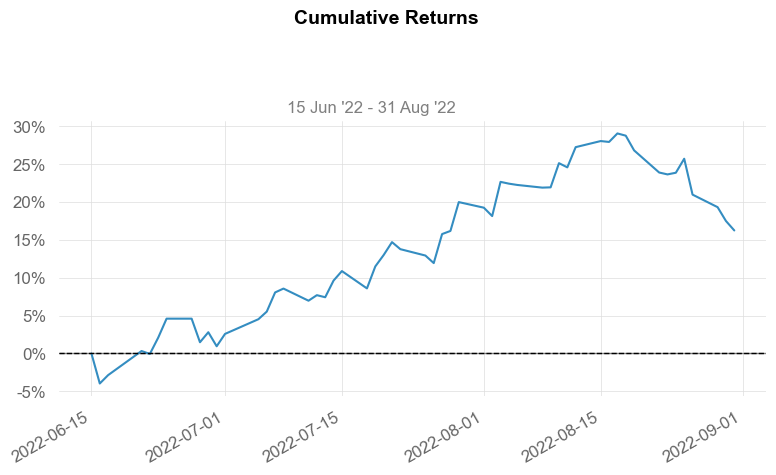

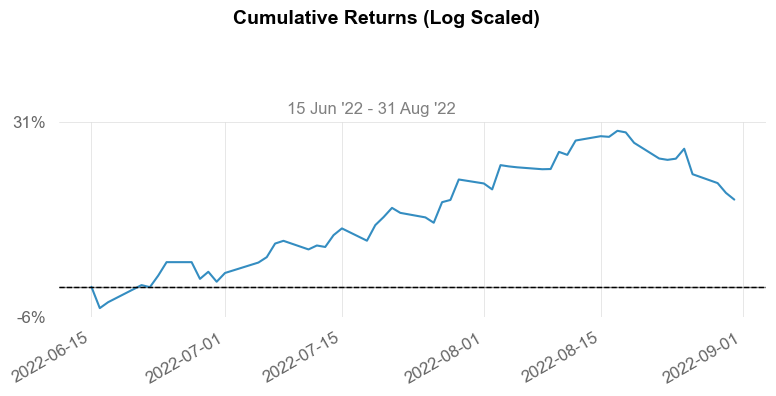

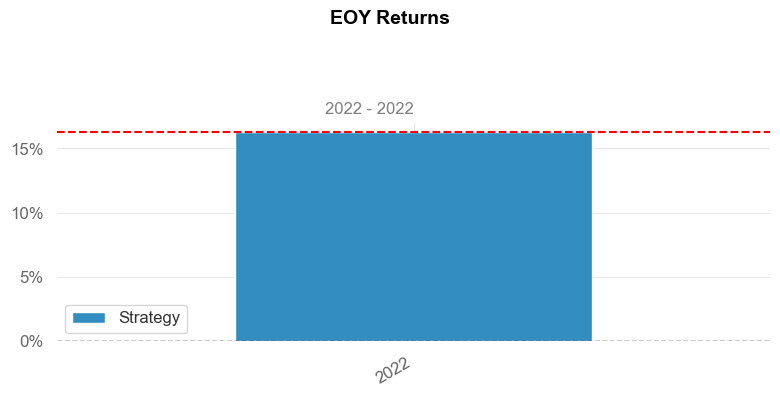

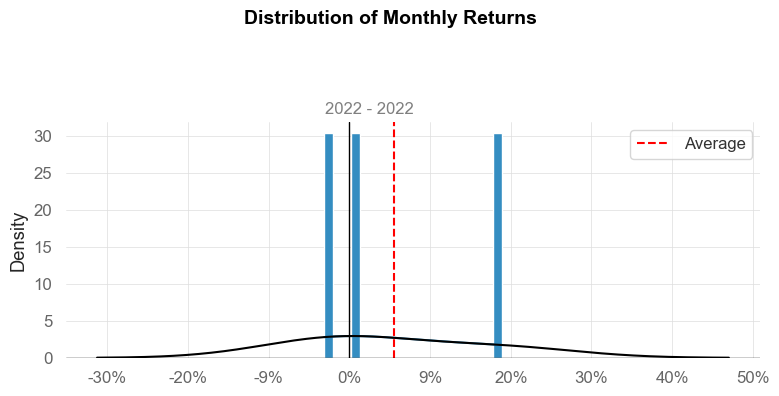

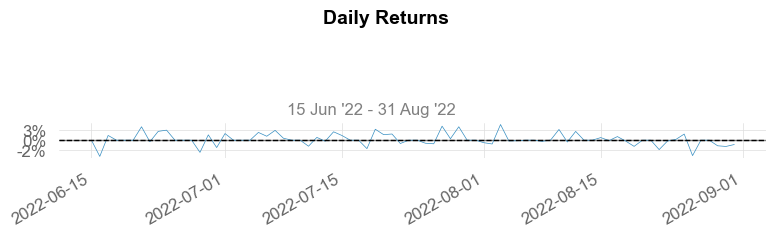

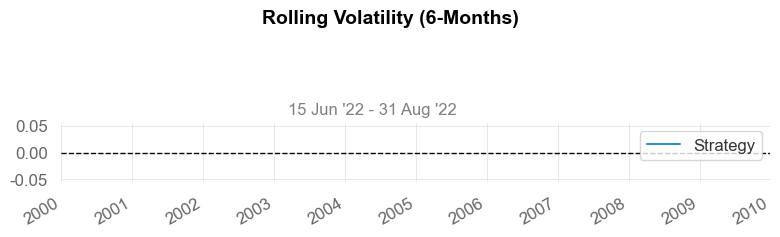

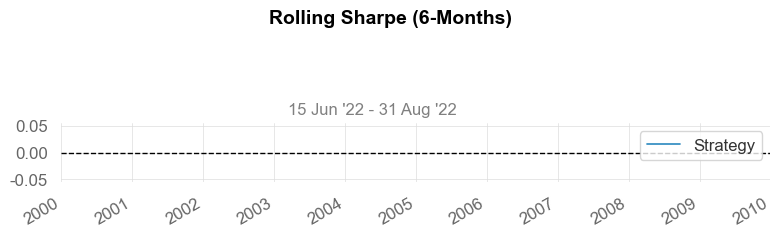

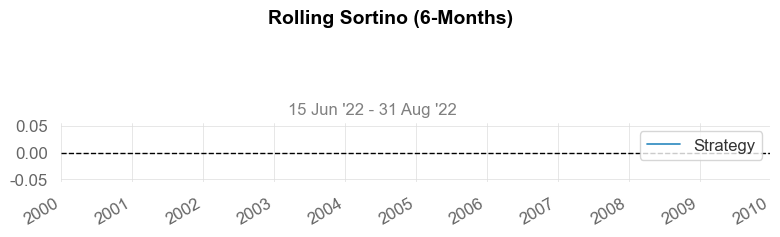

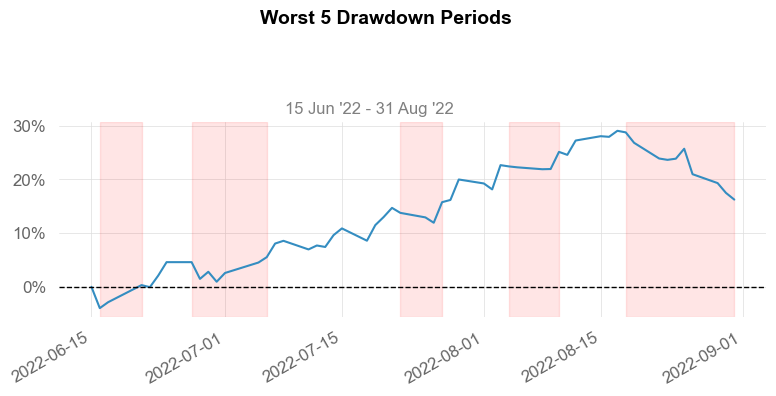

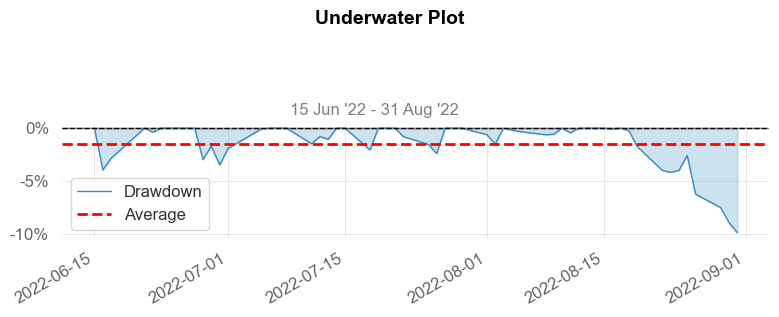

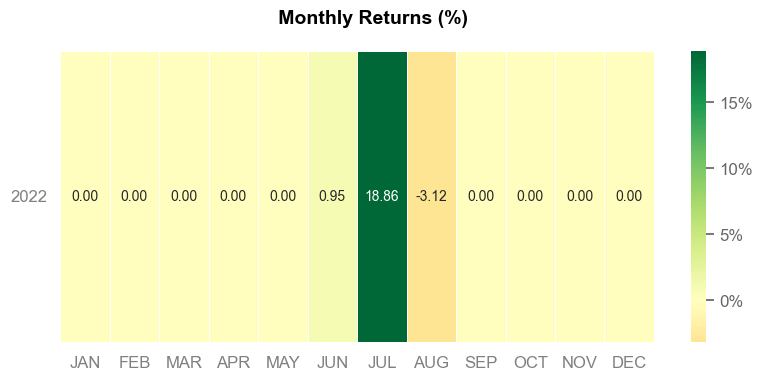

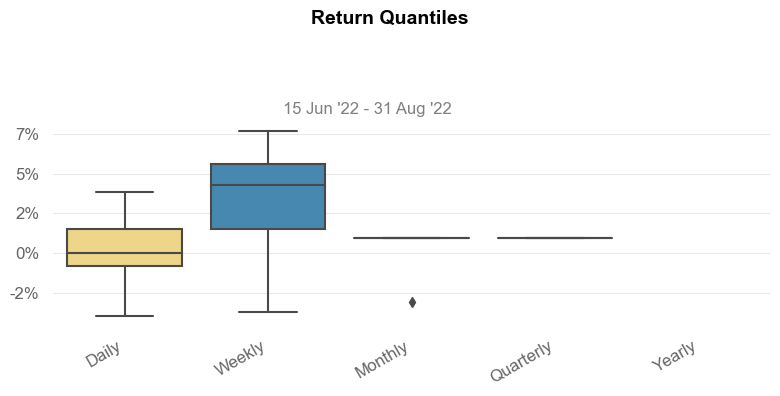

In [156]:
ModelwSentiment()

100%|██████████| 1/1 [00:00<00:00,  4.43it/s]

Xhist.shape (173, 20)
yhist.shape (173, 1)
Xyhist.shape (173, 21)
ols.rsquared Date
2021-12-23    NaN
2021-12-27    NaN
2021-12-28    NaN
2021-12-29    NaN
2021-12-30    NaN
             ... 
2022-08-25    1.0
2022-08-26    1.0
2022-08-29    1.0
2022-08-30    1.0
2022-08-31    1.0
Length: 173, dtype: float64
retsSpreads.index RangeIndex(start=0, stop=54, step=1)
type(retsSpreads.index) <class 'pandas.core.indexes.range.RangeIndex'>
type(retsSpreads['Date']) <class 'pandas.core.series.Series'>
type(retsSpreads['Date'][0]) <class 'datetime.date'>


                           Strategy
-------------------------  ----------
Start Period               2022-06-15
End Period                 2022-08-31
Risk-Free Rate             2.0%
Time in Market             99.0%

Cumulative Return          16.25%
CAGR﹪                     104.17%

Sharpe                     2.56
Prob. Sharpe Ratio         85.35%
Smart Sharpe               2.48
Sortino                    4.13
Smart Sortino              4.0
Sortino/√2                 2.92
Smart Sortino/√2           2.83
Omega                      1.51

Max Drawdown               -9.93%
Longest DD Days            13
Volatility (ann.)          28.22%
Calmar                     10.49
Skew                       -0.16
Kurtosis                   -0.16

Expected Daily %           0.28%
Expected Monthly %         5.15%
Expected Yearly %          16.25%
Kelly Criterion            18.3%
Risk of Ruin               0.0%
Daily Value-at-Risk        -2.63%
Expected Shortfall (cVaR)  -2.63%

Max Consecutive Wins     

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2022-08-18,2022-08-31,2022-08-31,13,-9.928356,-8.960152
2,2022-06-16,2022-06-16,2022-06-21,5,-3.965124,-2.857551
3,2022-06-28,2022-06-30,2022-07-06,8,-3.487202,-2.978942
4,2022-07-22,2022-07-26,2022-07-27,5,-2.413894,-1.544899
5,2022-07-18,2022-07-18,2022-07-19,1,-2.064322,0.000000


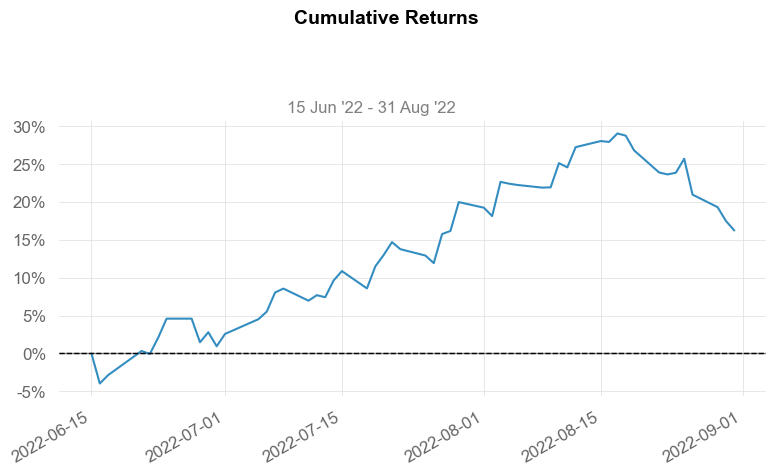

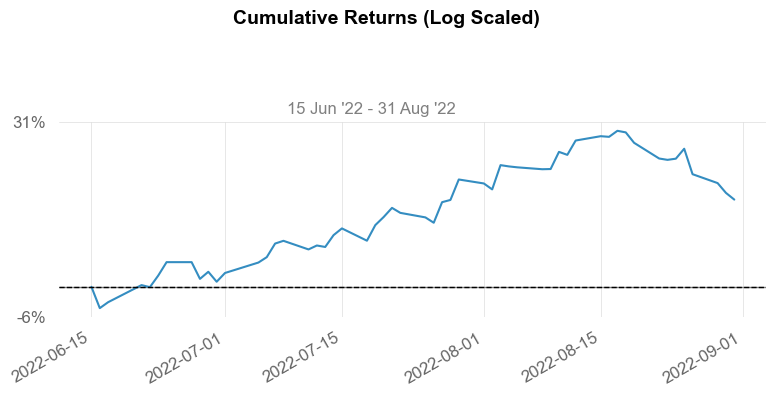

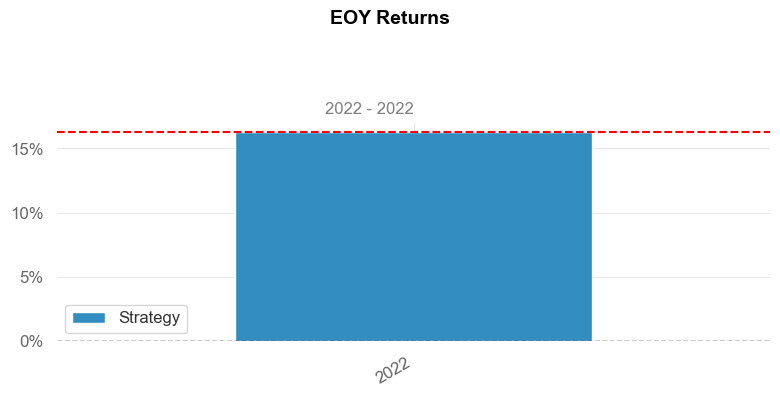

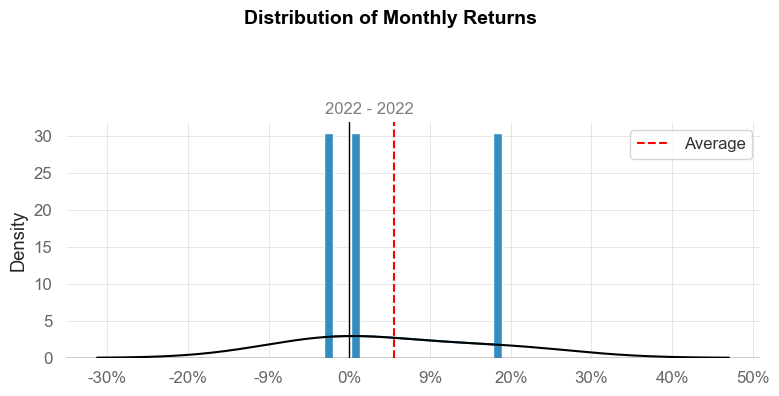

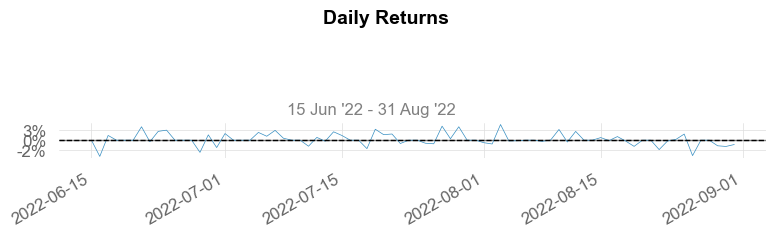

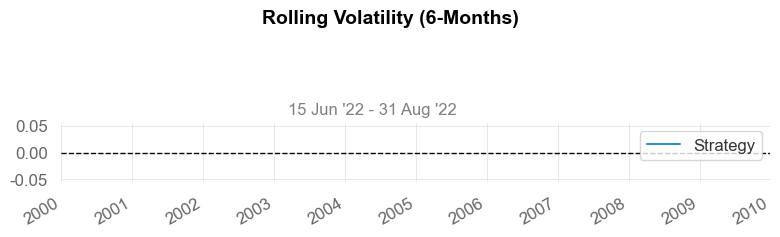

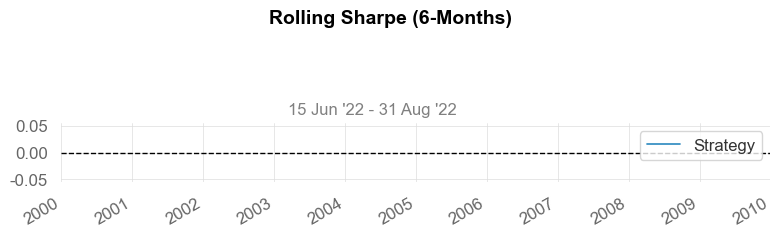

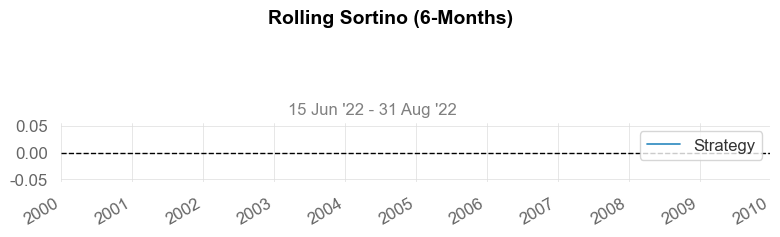

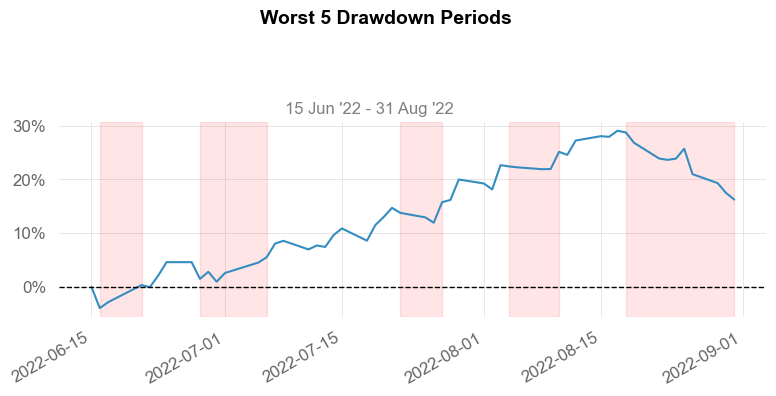

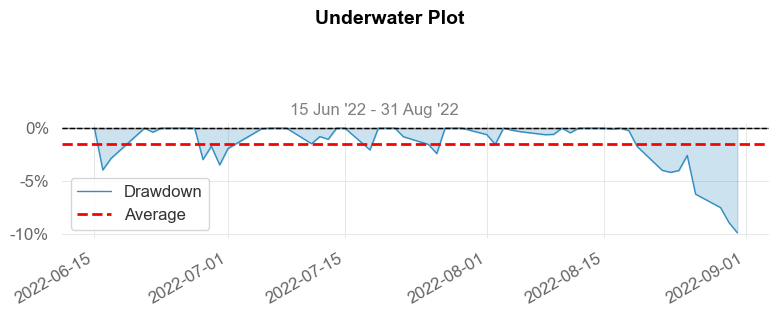

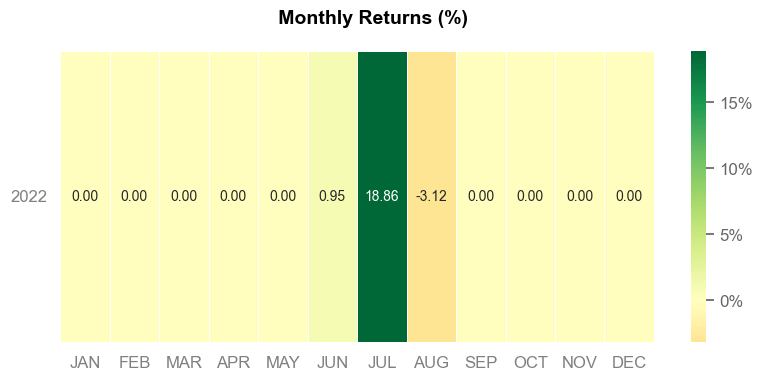

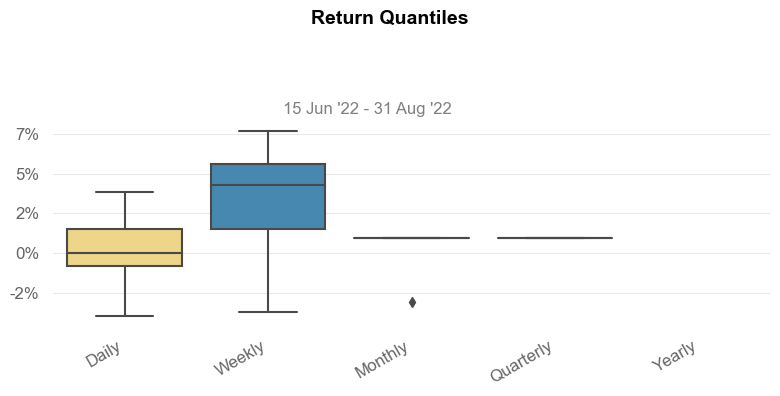

In [141]:
ModelwSentiment(['AAPL'], top20_it_comm_stocks)

100%|██████████| 1/1 [00:00<00:00,  3.96it/s]

Xhist.shape (173, 20)
yhist.shape (173, 1)
Xyhist.shape (173, 21)
ols.rsquared Date
2021-12-23         NaN
2021-12-27         NaN
2021-12-28         NaN
2021-12-29         NaN
2021-12-30         NaN
                ...   
2022-08-25    0.718982
2022-08-26    0.707421
2022-08-29    0.706348
2022-08-30    0.705033
2022-08-31    0.704813
Length: 173, dtype: float64
retsSpreads.index RangeIndex(start=0, stop=54, step=1)
type(retsSpreads.index) <class 'pandas.core.indexes.range.RangeIndex'>
type(retsSpreads['Date']) <class 'pandas.core.series.Series'>
type(retsSpreads['Date'][0]) <class 'datetime.date'>


                           Strategy
-------------------------  ----------
Start Period               2022-06-15
End Period                 2022-08-31
Risk-Free Rate             2.0%
Time in Market             99.0%

Cumulative Return          6.93%
CAGR﹪                     37.41%

Sharpe                     1.94
Prob. Sharpe Ratio         78.83%
Smart Sharpe               1.92
Sortino                    3.05
Smart Sortino              3.03
Sortino/√2                 2.16
Smart Sortino/√2           2.14
Omega                      1.39

Max Drawdown               -3.45%
Longest DD Days            15
Volatility (ann.)          15.77%
Calmar                     10.84
Skew                       -0.02
Kurtosis                   0.3

Expected Daily %           0.12%
Expected Monthly %         2.26%
Expected Yearly %          6.93%
Kelly Criterion            16.69%
Risk of Ruin               0.0%
Daily Value-at-Risk        -1.51%
Expected Shortfall (cVaR)  -1.51%

Max Consecutive Wins       8

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2022-08-16,2022-08-31,2022-08-31,15,-3.452338,-3.372257
2,2022-08-05,2022-08-09,2022-08-15,10,-2.697458,-1.679158
3,2022-06-27,2022-06-30,2022-07-07,10,-2.674172,-2.493369
4,2022-06-16,2022-06-16,2022-06-23,7,-2.296037,-2.019316
5,2022-07-11,2022-07-11,2022-07-20,9,-1.952414,-1.861966


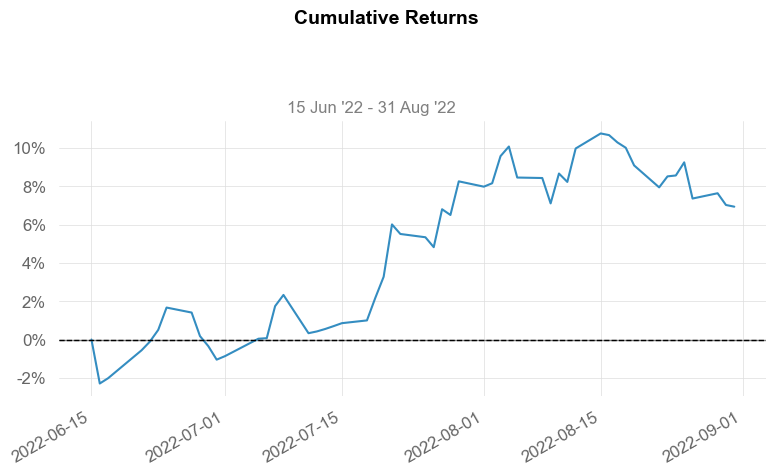

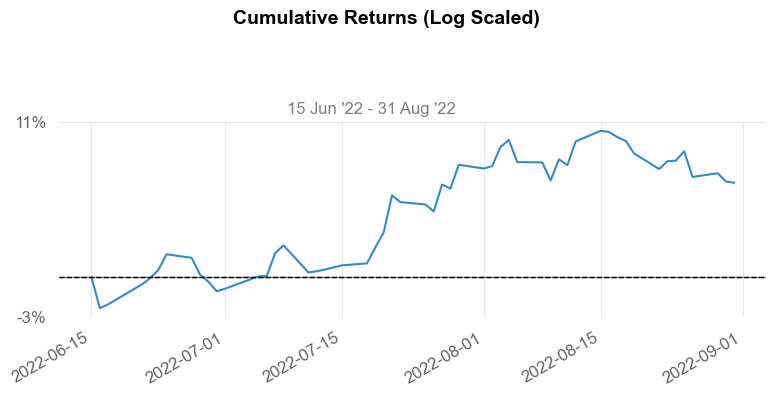

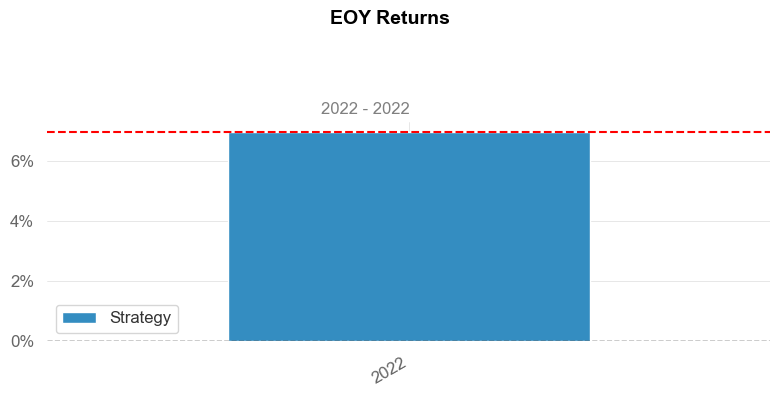

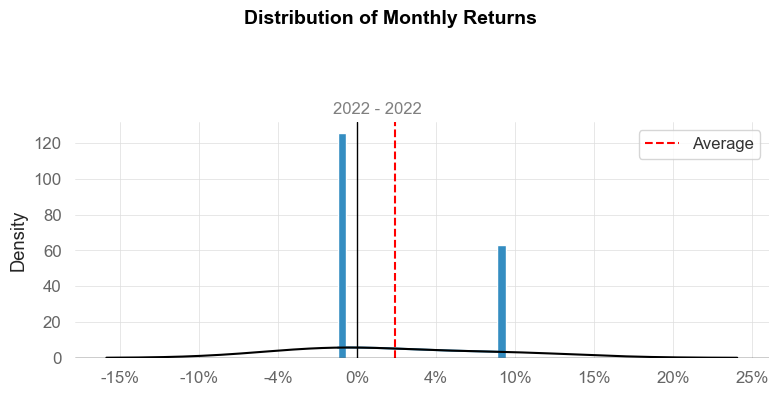

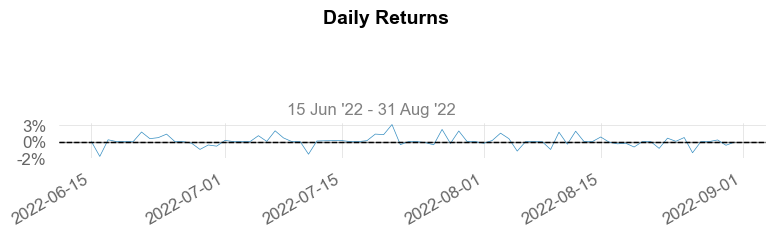

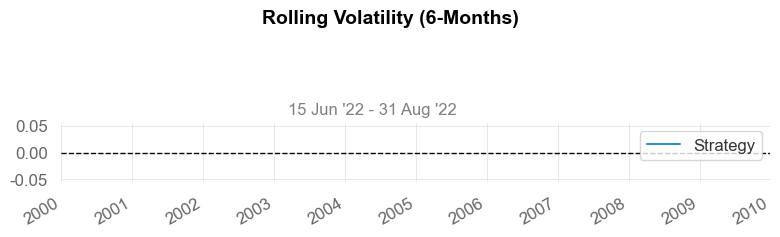

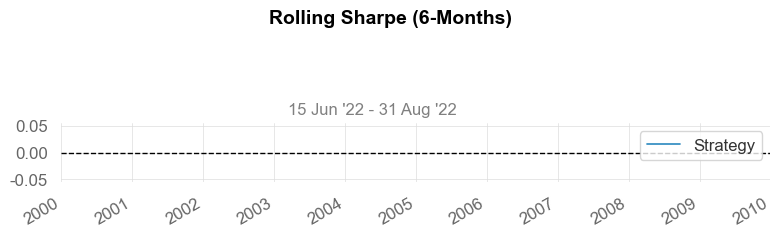

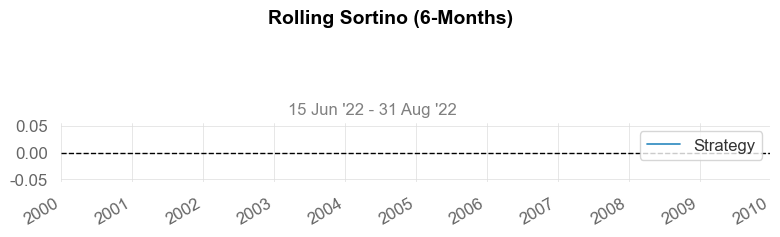

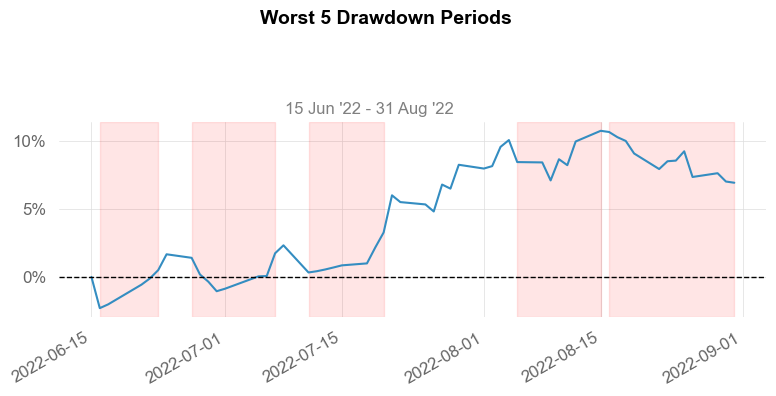

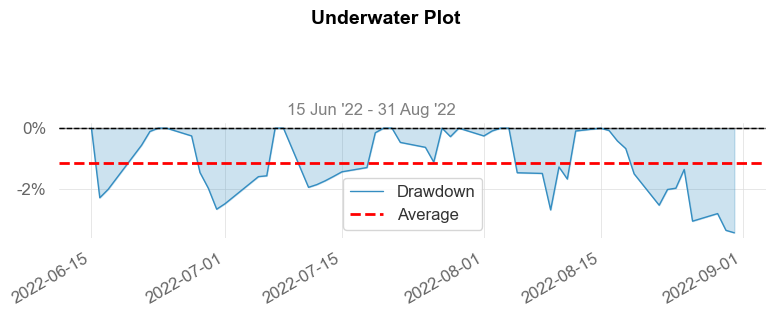

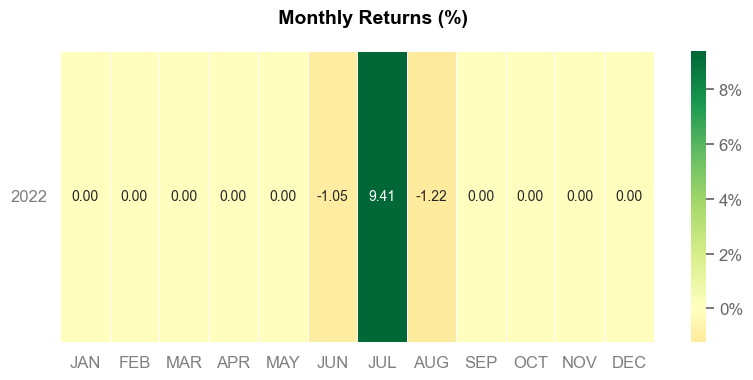

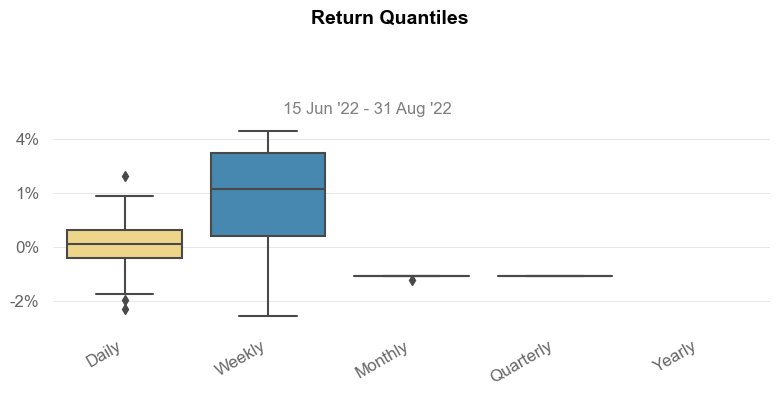

In [27]:
ModelwSentiment(tickers_to_predict=['TSLA'])

  0%|          | 0/1 [00:00<?, ?it/s]

Xhist.shape (173, 20)
yhist.shape (173, 1)
Xyhist.shape (173, 21)


100%|██████████| 1/1 [00:00<00:00,  1.36it/s]

ols.rsquared Date
2021-12-23    NaN
2021-12-27    NaN
2021-12-28    NaN
2021-12-29    NaN
2021-12-30    NaN
             ... 
2022-08-25    1.0
2022-08-26    1.0
2022-08-29    1.0
2022-08-30    1.0
2022-08-31    1.0
Length: 173, dtype: float64
retsSpreads.index RangeIndex(start=0, stop=54, step=1)
type(retsSpreads.index) <class 'pandas.core.indexes.range.RangeIndex'>
type(retsSpreads['Date']) <class 'pandas.core.series.Series'>
type(retsSpreads['Date'][0]) <class 'datetime.date'>


                           Strategy
-------------------------  ----------
Start Period               2022-06-15
End Period                 2022-08-31
Risk-Free Rate             2.0%
Time in Market             99.0%

Cumulative Return          -3.79%
CAGR﹪                     -16.74%

Sharpe                     -0.13
Prob. Sharpe Ratio         42.56%
Smart Sharpe               -0.12
Sortino                    -0.19
Smart Sortino              -0.18
Sortino/√2                 -0.13
Smart Sortino/√2           -0.13
Omega                      0.98

Max Drawdown               -14.2%
Longest DD Days            40
Volatility (ann.)          52.0%
Calmar                     -1.18
Skew                       0.13
Kurtosis                   -0.19

Expected Daily %           -0.07%
Expected Monthly %         -1.28%
Expected Yearly %          -3.79%
Kelly Criterion            -0.74%
Risk of Ruin               0.0%
Daily Value-at-Risk        -5.41%
Expected Shortfall (cVaR)  -5.41%

Max Consecutive W

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2022-07-22,2022-08-30,2022-08-31,40,-14.199921,-13.140794
2,2022-07-08,2022-07-14,2022-07-19,11,-8.211859,-5.406817
3,2022-06-16,2022-06-22,2022-06-24,8,-7.971656,-7.263066
4,2022-06-27,2022-07-01,2022-07-07,10,-5.953223,-5.571233


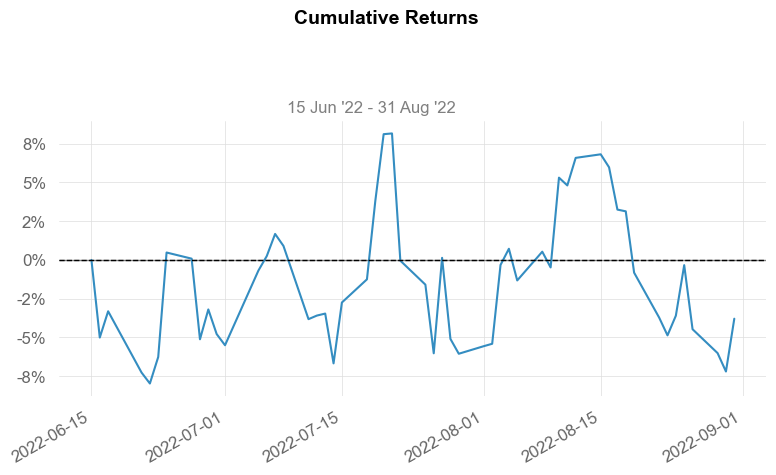

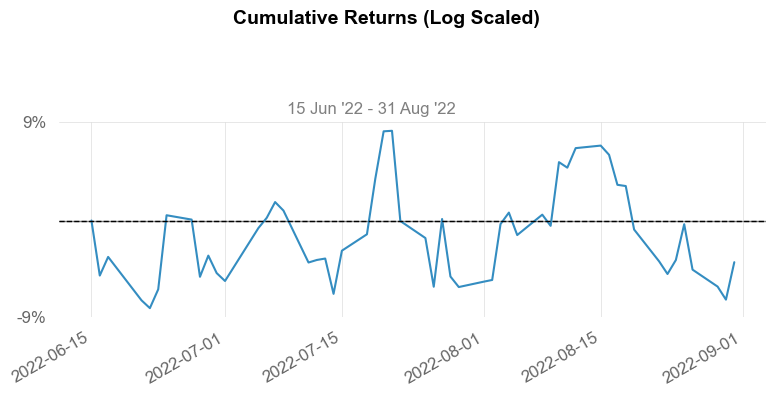

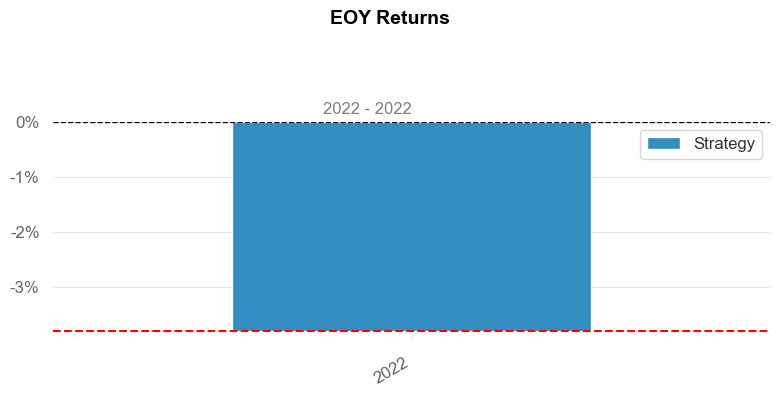

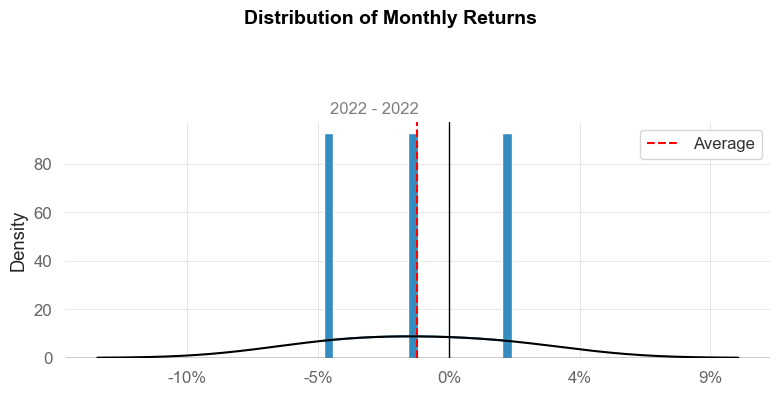

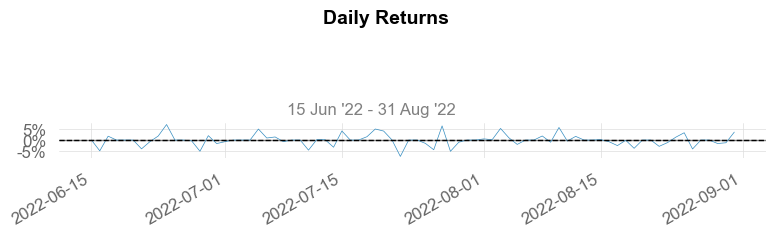

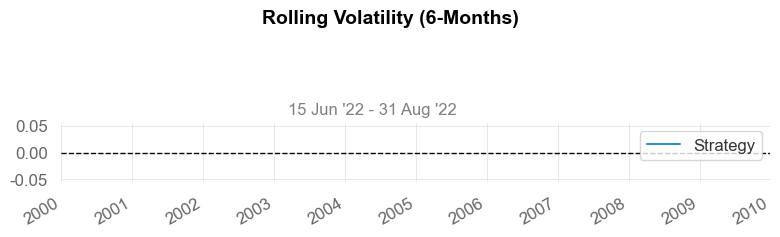

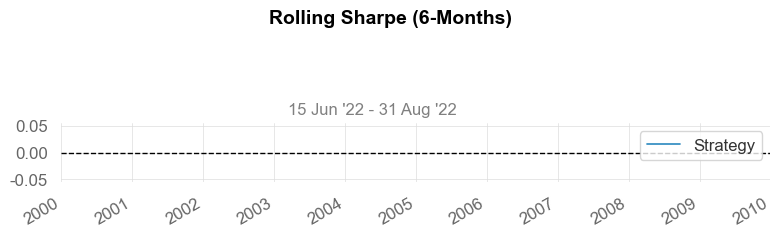

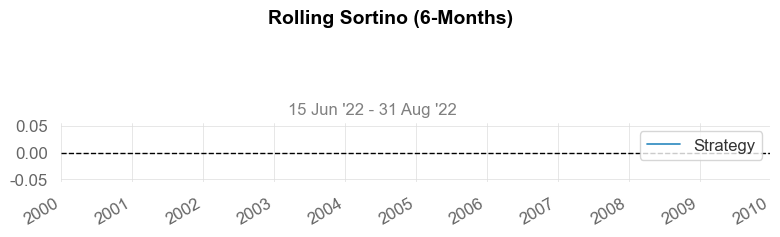

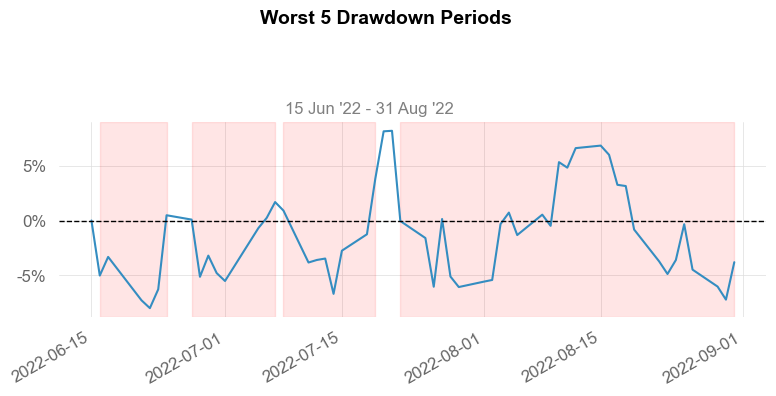

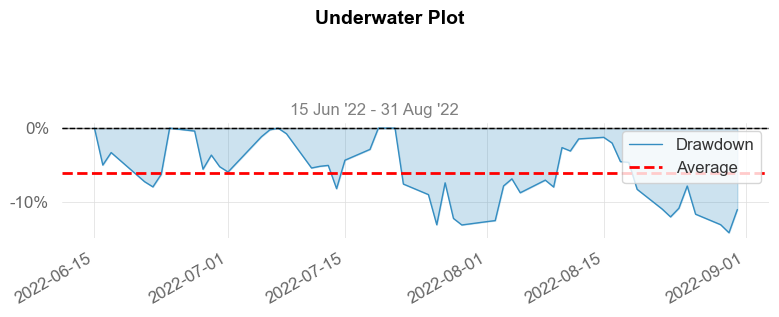

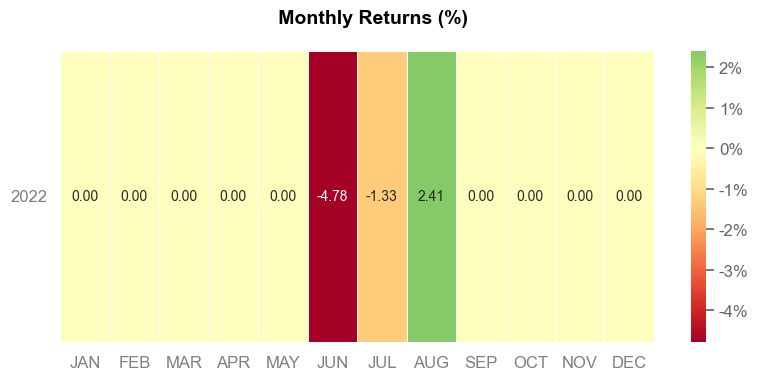

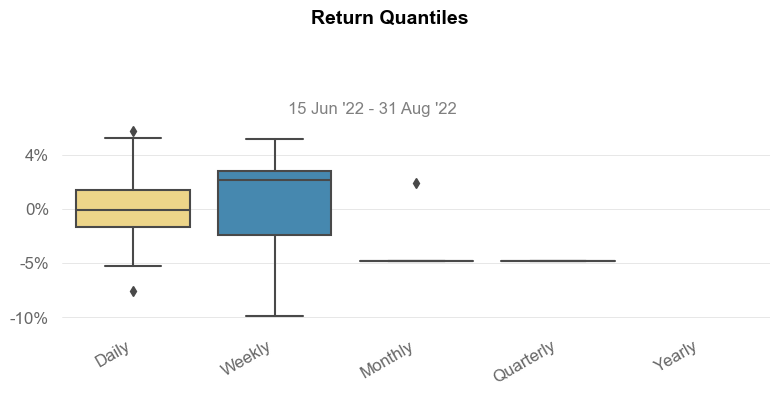

In [28]:
ModelwSentiment(tickers_to_predict=['META'])